![image](../pic/pic1.jpg)
![image](../pic/pic2.jpg)

Длинные названия потому, что за жизненным циклом обектов следить не умею :)

Симулирую **ТОЛЬКО** создание новых связей

In [1]:
Generate_Network_t0 <- function(size = 40, sparsity = 0.7) {
	network <- matrix(0, nrow=size, ncol=size)
  
	for (i in 1:size) {
		for (j in 1:size) {
			if (runif(1) > sparsity) {
				network[i, j] <- 1
			}
		}
	}
  
	return(network)
}


Network_function_1 <- function(i, Network) { # outdegree (density)
	net <- sum(Network[i, ])
	return(net)
}


Network_function_2 <- function(i, Network) { # recip
	net <- 0
    for(j in 1:length(Network[1,])){
        if(i != j){
            net <- net + Network[i,j]*Network[j,i]
        }
    }
	return(net)
}

Network_function_3 <- function(i, Network) { # transitive triads (transTrip)
	net <- 0
	for (j in 1:length(Network[i, ])) {
		for(h in 1:length(Network[i, ])){
			if(i!=j & j!=h & i!=h){
				net <- net + (Network[i,j] * Network[i,h] * Network[h,j]) 
			}
		}
	}
	return(net)
}

Generate_Possible_Ministep_Matrix_vector <- function(i, Network) {
	Networks <- list()
  
	for (j in 1:length(Network[i, ])) {
		if (i != j) {
			TMP_Net <- Network
			TMP_Net[i, j] <- 1
			Networks[[j]] <- TMP_Net    
		}
	}
	return(Networks)
}

Ministep <- function(Network, i, j) {
	Network[i, j] <- 1
	return(Network)
}


Distribution_actors <- function(i, Network, beta) {
	Util <- numeric( length(Network[i, ]) )
	total_util <- 0
  
	for (h in 1:length(Network[i, ])) {
		if (i != h) {
			total_util <- total_util + exp(Utility(Network, beta, i, h))
		}
	}
  
	Util_j <- numeric(length(Network[i, ]))
  
	for (j in 1:length(Network[i, ])) {
		if (j != i) {
			Util_j[j] <- exp(Utility(Network, beta, i, j))
            # print(Util_j[j])
            # print(total_util)
			Util[j] <- Util_j[j] / total_util
		}
	}
    # print(i)
    # print(Util) # На всех шагах всегда матирциа полезности одинкова для всех акторах. Странно
	# На сетях 1 и 2 матрица полезностей так же идентична
    Util[which(is.na(Util))] <- 0
	return(Util)
}

Utility <- function(Network, beta, i, j) {
	util <- 0
	util <- util + (beta[1] * Network_function_2(i, Network)) + (beta[2] * Network_function_3(i, Network))
	return(util)
}

Simulator <- function(Network0, t = 0, LambdaV, total_Lambda, T, beta) {
	Network <- Network0 
	while (t < T) {
		deltaT <- rexp(1, rate=total_Lambda)
		i <- sample(1:length(Network0[1, ]), size=1, prob=(LambdaV / total_Lambda))
      
		prob_vector <- 0
		prob_vector <- Distribution_actors(i, Network, beta)
        # print(sum(prob_vector))
		j <- sample(1:length(Network0[i,]), size=1, prob=prob_vector)
		Network[i, j] <- 1
		t <- t + deltaT

	}
	return(Network)
}

In [2]:
size <- 30
Network0 <- Generate_Network_t0(size = size)
LambdaV <- runif(n = size, min = 0, max = 1) 
total_Lambda <- sum(LambdaV)
# total_Lambda
beta <- runif(n = 2, min = 0, max = 1)
# beta <- c(.3,.6)
T <- 3
# total_Lambda

In [3]:
Network1 <- Simulator(Network0, t = 0, LambdaV, total_Lambda, T, beta)

In [4]:
Network2 <- Simulator(Network1, t = 0, LambdaV, total_Lambda, T, beta)

In [5]:
sum(Network0)
sum(Network1)
sum(Network2)

[1] 271

[1] 300

[1] 330

---
# Проверка в RSiena

In [6]:
library(RSiena)

In [7]:
Networks <- array(c(Network0, Network1, Network2), dim = c(size, size, 3))

Networks <- sienaDependent(Networks, nodeSet="Actors")

Networks
     

Type         oneMode             
Observations 3                   
Nodeset      Actors (30 elements)


In [8]:
mydata <- sienaDataCreate(Networks)
myeff <- getEffects(mydata)
mydata

For dependent variable Networks, in some periods,

there are only increases, or only decreases.

This will be respected in the simulations. 

If this is not desired, use allowOnly=FALSE when creating the dependent variable.



Dependent variables:  Networks 
Number of observations: 3 

Nodeset                  Actors 
Number of nodes              30 

Dependent variable Networks     
Type               oneMode      
Observations       3            
Nodeset            Actors       
Densities          0.3 0.33 0.37

"uponly":  Networks:    all periods

Сиена видит коэффиценты разреженности. Они идентичны заданным.

Так же в предупреждении указано, что сеть только увеличивалась или уменьшалась, что корректно отвечает заданным условиям. 

In [9]:
effectsDocumentation(myeff,type = "html", display = FALSE)

Effects documentation written to file myeff.html .


In [10]:
myeff <- includeEffects(myeff, recip  , type = "creation", include = TRUE)
myeff <- includeEffects(myeff, recip  , type = "eval", include = FALSE)
myeff <- includeEffects(myeff, transTrip, type = "creation", include = TRUE)
# myeff <- includeEffects(myeff, transTrip, include = TRUE)

  effectName  include fix   test  initialValue parm type    
1 reciprocity TRUE    FALSE FALSE          0   0    creation
[1] effectName   include      fix          test         initialValue
[6] parm        
<0 rows> (or 0-length row.names)
  effectName          include fix   test  initialValue parm type    
1 transitive triplets TRUE    FALSE FALSE          0   0    creation


In [11]:
summary(myeff)

,name,effectName,functionName,shortName,interaction1,interaction2,type,basicRate,include,randomEffects,⋯,effect3,interactionType,local,setting,effectFn,statisticFn,netType,groupName,group,effectNumber
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,⋯,<int>,<chr>,<lgl>,<chr>,<list>,<list>,<chr>,<chr>,<dbl>,<int>
Networks.rate.1,Networks,constant Networks rate (period 1),Amount of network change in period 1,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,1
Networks.rate.2,Networks,constant Networks rate (period 2),Amount of network change in period 2,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,2
Networks.obj.creation.1,Networks,reciprocity,New ties: Number of reciprocated ties,recip,,,creation,FALSE,TRUE,FALSE,⋯,0,dyadic,TRUE,,NULL,NULL,oneMode,Group1,1,14
Networks.obj.creation.2,Networks,transitive triplets,New ties: Number of transitive triplets,transTrip,,,creation,FALSE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,20


In [12]:
myalgorithm <- sienaAlgorithmCreate(projname = 'Тест симулятора сети')
ans <- siena07( myalgorithm, data = mydata,silent = TRUE ,effects = myeff,batch = TRUE, clusterType="FORK", useCluster=TRUE, nbrNodes=12)

If you use this algorithm object, siena07 will create/use an output file Тест симулятора сети.txt .


In [13]:
ans

Estimates, standard errors and convergence t-ratios

                                    Estimate   Standard   Convergence 
                                                 Error      t-ratio   

Rate parameters: 
  0.1       Rate parameter period 1 0.9835   ( 0.1821   )             
  0.2       Rate parameter period 2 1.0126   ( 0.1847   )             

Other parameters: 
  1.  creat reciprocity             0.1410   ( 0.3077   )    0.0475   
  2.  creat transitive triplets     0.1616   ( 0.1281   )   -0.0019   

Overall maximum convergence ratio:    0.0475 


Total of 1380 iteration steps.


Необходимо помнить, что оцениваем $ exp(\text{парамтер}) $ (Для созданных мной параметров)

---
Скриптом `../data/main.r` запустил 40 повторов. Графики сходимости (сходимости ли ?).
В скрипт немного отличается от Ноубтбука. Правки вроде случайных начальных парметров

beta - мои параметры. 
- beta1 - density
- beta2 - transTrip

teta - оцененые параметры

rate - оцененая скорость
- rate1 - 1 период
- rate2 - 2 период

totalLambda - суммарная интенсивность всех акторов (задана)

In [15]:
beta <- read.table("../data/beta.txt", sep = " ")
rate <- read.table("../data/rate.txt", sep = " ")
teta <- read.table("../data/teta.txt", sep = " ") # Почему то записывается только первый столбец, 
                                                  # но если запустить в jupyter 
                                                  # То выводятся оба
total_Lambda <- read.table("../data/totalLambda.txt", sep = " ")

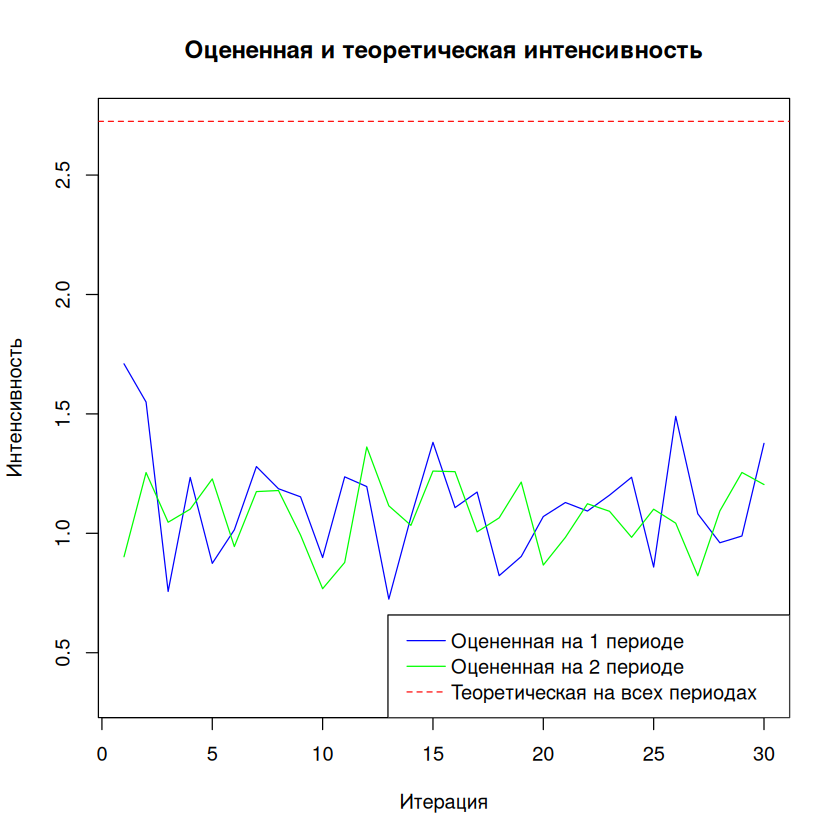

In [28]:
log_total_lambda <- log((total_Lambda$V1[1]))

min_y <- min(min(rate$V1), min(rate$V2), log_total_lambda) - .4
max_y <- max(max(rate$V1), max(rate$V2), log_total_lambda)

plot(rate$V1, type = "l", col = "blue", ylim = c(min_y, max_y), 
     xlab = "Итерация", ylab = "Интенсивность", main = "Оцененная и теоретическая интенсивность")

lines(rate$V2, type = "l", col = "green")
abline(h = log_total_lambda, col = "red", lty = 2)

legend("bottomright", legend = c("Оцененная на 1 периоде", "Оцененная на 2 периоде", "Теоретическая на всех периодах"),
       col = c("blue", "green", "red"), lty = c(1, 1, 2), x.intersp = .3)




[1] -0.1537533

[1] 0.1365762

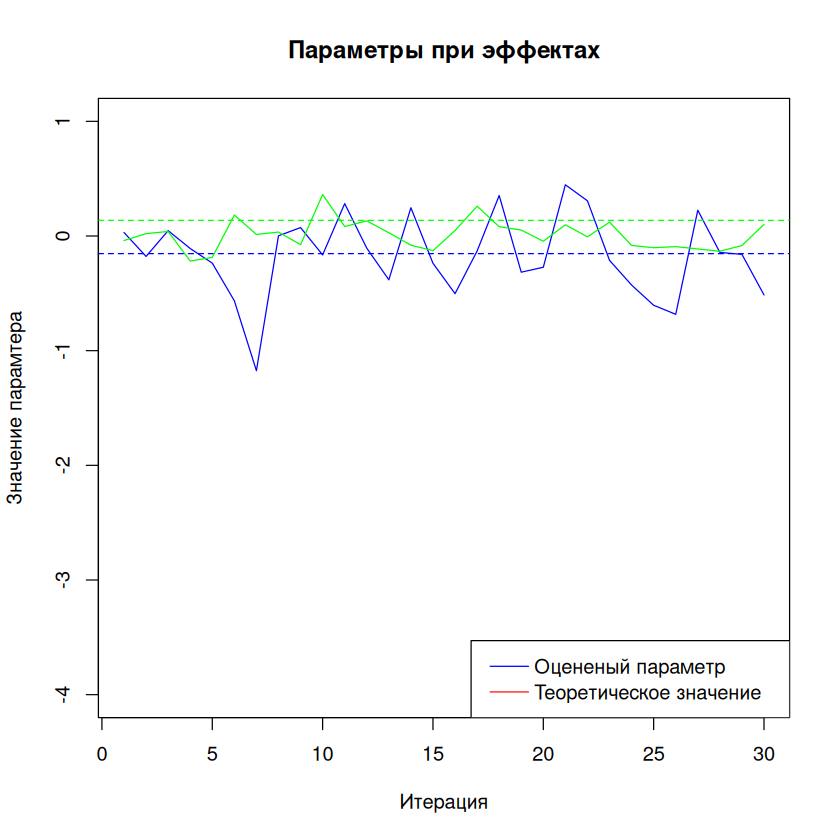

In [29]:
# Верно ли интерпертирую эффекты?

log(beta$V1[1])
sqrt(beta$V2[1])

plot(teta$V1, type="l", col="blue", ylim=c(-4, 1), main = "Параметры при эффектах", xlab = "Итерация", ylab = "Значение парамтера",)
abline(h = log(beta$V1[1]), col = "blue", lty = 2)
abline(h = sqrt(beta$V2[1]),col = "green", lty = 2)
lines(teta$V2, col = "green")

legend("bottomright", legend = c("Оцененый параметр", "Теоретическое значение"),
       col = c("blue", "red"), lty = c(1, 1), x.intersp = .3)

In [18]:
mean(teta$V1)
mean(teta$V2)

[1] -0.1702433

[1] 0.00895077

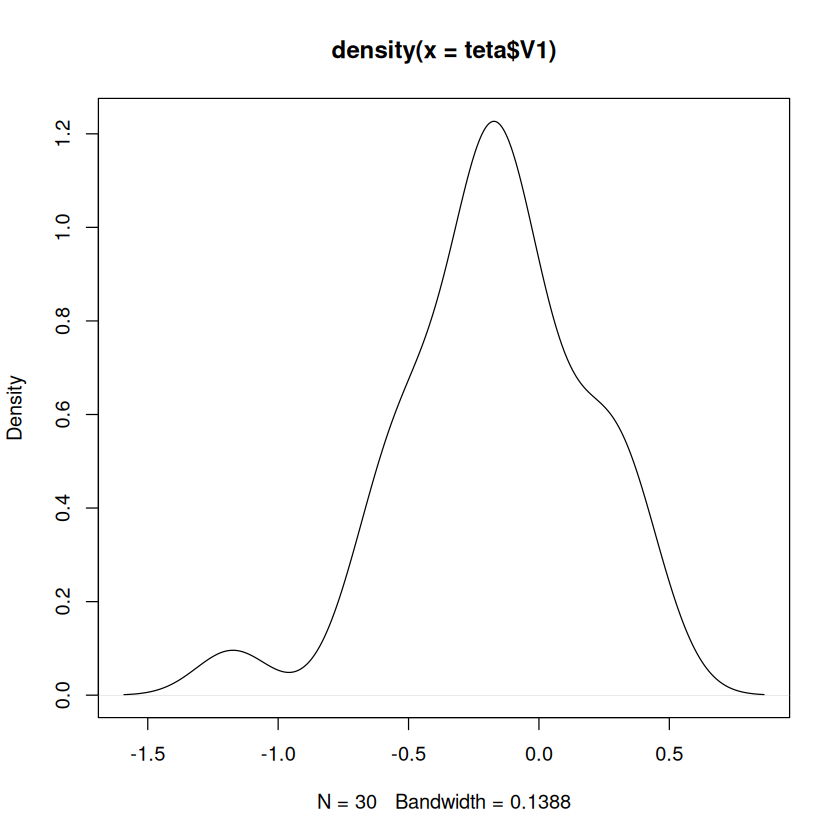

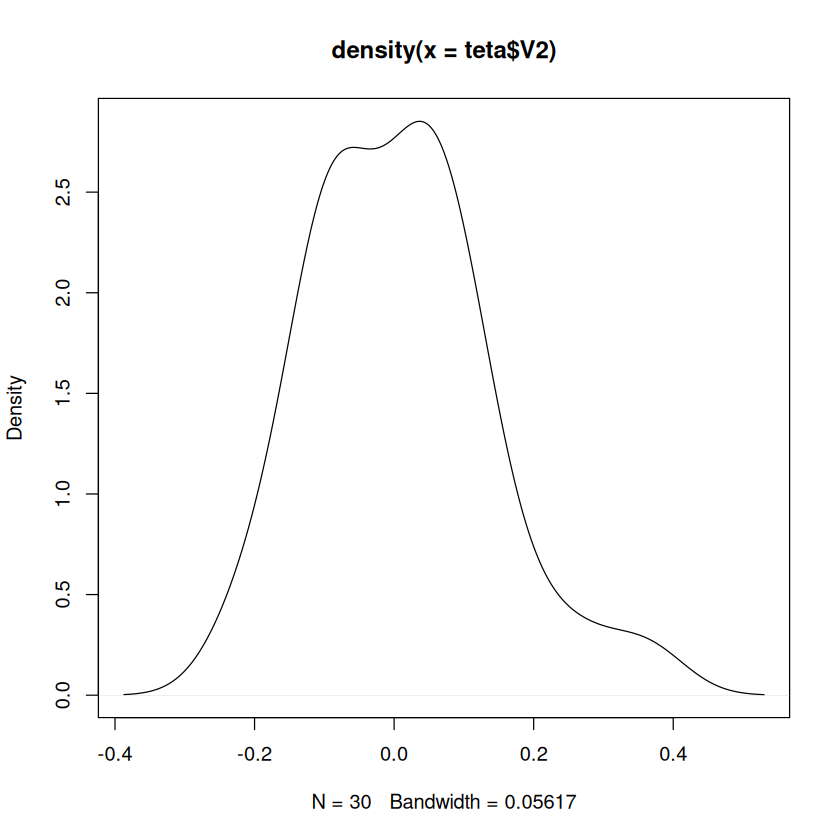

In [19]:
plot(density(teta$V1))
plot(density(teta$V2))